In [1]:
# !pip install -U memory_profiler
# !pip install ipywidgets
# !pip install scipy
# !pip install scikit-learn
#numpy, pandas, matplotlib
# !pip install seaborn

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as spa
import scipy.linalg as la
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns
import time
from urllib.request import urlretrieve
from collections import defaultdict
import ipywidgets as widgets
from IPython.display import display
from sklearn.model_selection import train_test_split
import warnings
import gc

# from memory_profiler import profile
# %load_ext memory_profiler

In [2]:
def download_data(url):
  """
    Download data from url
  """
  filename = os.path.basename(url)
  if not os.path.exists(filename):
    path, _ = urlretrieve(url, filename)
    print("Data downloaded successfuly !")
  else:
    print("Data already downloaded")

download_data('https://files.grouplens.org/datasets/movielens/ml-latest-small.zip')

Data already downloaded


In [3]:
def extract_data(filename, extract_to_path):
  """
    Extract data into project director
  """
  file_dir = os.path.join(extract_to_path, os.path.basename(filename).split('.')[0])
  # extract file into the project directory
  if not os.path.exists(file_dir)and os.path.exists(filename):
    with ZipFile(filename, 'r') as zf:
      zf.extractall(path=extract_to_path)
      print(f"Extracted to {file_dir} directory")
  else:
    print("Data already extracted")

extract_data("ml-latest-small.zip", './data')

Data already extracted


**Date Load and EDA**

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.


In [4]:
# load data of movies and ratings
data_dir = "./data/ml-latest-small"
movies_df = pd.read_csv(os.path.join(data_dir, "movies.csv"))
ratings_df = pd.read_csv(os.path.join(data_dir, "ratings.csv"))

In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# sort the ratings based on userId and movieId for later use
# ratings_df.sort_values(by=['userId', 'movieId']).reset_index(drop=True, inplace=True)

In [8]:
#total number of records
print(f"#ratings: {ratings_df.shape[0]}")
print(f"#movies: {movies_df.shape[0]}")

#ratings: 100836
#movies: 9742


In [9]:
#merege the two dataframes with the movieId(common column)
movie_ratings_df = pd.merge(ratings_df, movies_df, on="movieId")

In [10]:
movie_ratings_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [11]:
#check null values
print(f"# null values:\n{movie_ratings_df.isna().sum()}\n")

#check if there is duplicated movies
print(f"duplicated movies: {movies_df['movieId'].duplicated().sum()}")

# null values:
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

duplicated movies: 0


In [12]:
#count how many unique user-movie pairs 
user_movie_pair_counts = movie_ratings_df.groupby(["userId", "movieId"]).size().reset_index(name="count")

#check if a user rated the same movie more than one time
num_duplicate_pairs = user_movie_pair_counts[user_movie_pair_counts["count"] > 1]["count"].sum()
print(f"#duplicate user-movie-pairs: {num_duplicate_pairs}")

#duplicate user-movie-pairs: 0


In [13]:
#number of unique users and movies
print(f"# unique users: {movie_ratings_df['userId'].nunique()}")
print(f"# unique movies: {movies_df['movieId'].nunique()}")
print(f"# unique movies with rating: {movie_ratings_df['movieId'].nunique()}")
print(f"# movies not rated: {movies_df[~movies_df['movieId'].isin(ratings_df['movieId'].unique())].shape[0]}")

# unique users: 610
# unique movies: 9742
# unique movies with rating: 9724
# movies not rated: 18


In [14]:
unrated_movies = movies_df[~movies_df['movieId'].isin(ratings_df['movieId'].unique())]
print(f"# unrated movies: {unrated_movies.shape[0]}")
print(f"Sample unrated movies:\n {unrated_movies.head()}")

# unrated movies: 18
Sample unrated movies:
       movieId                                         title  \
816      1076                         Innocents, The (1961)   
2211     2939                                Niagara (1953)   
2499     3338                        For All Mankind (1989)   
2587     3456  Color of Paradise, The (Rang-e khoda) (1999)   
3118     4194                I Know Where I'm Going! (1945)   

                     genres  
816   Drama|Horror|Thriller  
2211         Drama|Thriller  
2499            Documentary  
2587                  Drama  
3118      Drama|Romance|War  


In [15]:
#most of the movies are 3 and above rated
most_rated_movie_count = movie_ratings_df['rating'].value_counts()[movie_ratings_df['rating'].\
value_counts().keys() >= 3.0].sum()
print(f"# rating dist(i.e rating >= 3.0) : {most_rated_movie_count}")

# rating dist(i.e rating >= 3.0) : 81763


In [16]:
# top 5 mean rating for movies
movies_grouped_by_movie = movie_ratings_df.groupby('movieId', sort=False)['rating']
movies_grouped_by_movie.mean().sort_values(ascending=False)

movieId
1151      5.0
115727    5.0
138632    5.0
107771    5.0
1631      5.0
         ... 
173307    0.5
165645    0.5
137517    0.5
8632      0.5
61818     0.5
Name: rating, Length: 9724, dtype: float64

In [17]:
# highly rated movies
rating_count = movies_grouped_by_movie.count().sort_values(ascending=False)
print(f"Sample of highly rated movies:\n {rating_count.head()}")

Sample of highly rated movies:
 movieId
356     329
318     317
296     307
593     279
2571    278
Name: rating, dtype: int64


In [18]:
#each user rated a minimum and a maximum of 20 movies and 2698 movies respectively
user_rating_count = movie_ratings_df.groupby("userId", sort=False)['title'].count().sort_values(ascending=False)
print(f"min # of movies rated by a user: {user_rating_count.min()}")
print(f"max # of movies rated by a user: {user_rating_count.max()}")

min # of movies rated by a user: 20
max # of movies rated by a user: 2698


In [19]:
#movies with more than 20 ratings
print(f"Movies with more than 20 ratings:\n {rating_count[rating_count >= 20].head()}")
print(f"# movies with more than 20 ratings:\n {rating_count[rating_count >= 20].count()}")
print(f"# movies with less than 20 ratings:\n {rating_count[rating_count < 20].count()}")
print(f"# movies with only 1 rating:\n {rating_count[rating_count <= 1].count()/ratings_df['movieId'].nunique()*100 :.2f}%")

Movies with more than 20 ratings:
 movieId
356     329
318     317
296     307
593     279
2571    278
Name: rating, dtype: int64
# movies with more than 20 ratings:
 1297
# movies with less than 20 ratings:
 8427
# movies with only 1 rating:
 35.44%


In [20]:
movie_ratings_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


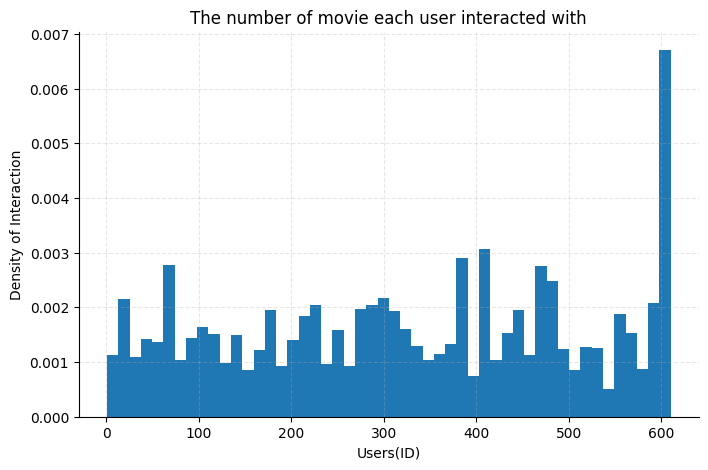

In [21]:
# The plot indicate some users rate many movies
plt.figure(figsize=(8, 5))
plt.hist(movie_ratings_df['userId'], bins=50, density=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlabel('Users(ID)')
plt.ylabel('Density of Interaction')
plt.title(f'The number of movie each user interacted with')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

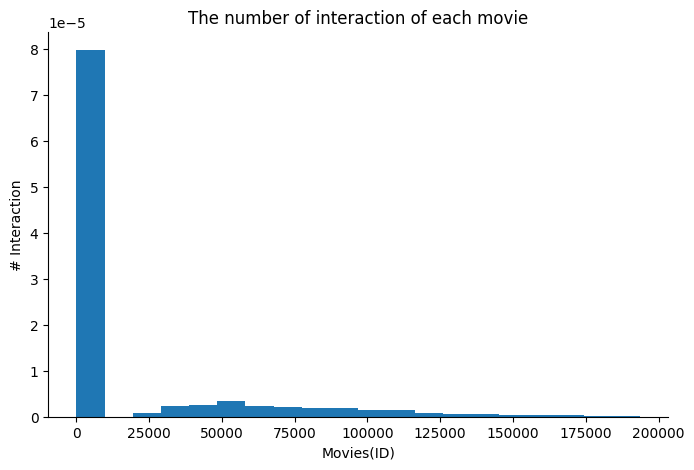

In [22]:
# This is the equivalent of the previous; some movies have been rated by many users
plt.figure(figsize=(8, 5))
plt.hist(movie_ratings_df['movieId'], bins=20, density=True)
plt.xlabel('Movies(ID)')
plt.ylabel('# Interaction')
plt.title(f'The number of interaction of each movie')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

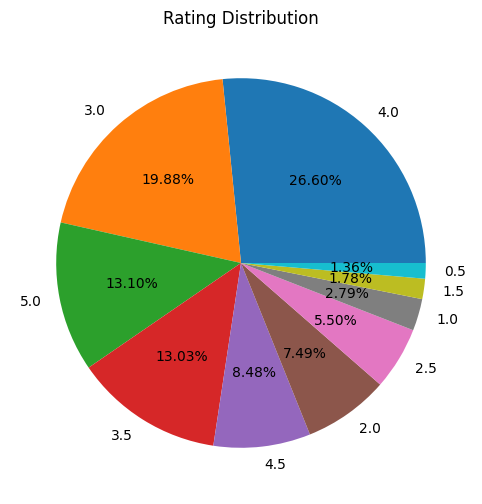

In [23]:
# This plot shows that the majority of the ratings are 4 and the minority is 0.5
plt.figure(figsize=(8, 6))
plt.pie(ratings_df['rating'].value_counts(), labels=ratings_df['rating'].value_counts().index, autopct="%1.2f%%")
plt.title('Rating Distribution')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

**Algorithm: The Iterative BiRank Algorithm**



**Input:** Weight matrix \( W \), query vectors \( p<sub>0</sub> \), \(u<sub>0</sub>), and hyper-parameters \(&alpha;, &beta; \)  
**Output:** Ranking vectors \( **p**, **u** \)  

1.  Symmetrically normalize \( W \):
  \[
   S = D<sub>u</sub><sup>-1/2</sup> W D<sub>p</sub><sup>-1/2</sup>
   \]
2.   Randomly initialize \( **p** \) and \( **u** \)
3. **while** Stopping criteria is not met **do**  
   \[
   p &larr; &alpha; S<sup>T</sup> u + (1 - &alpha;) p<sub>0</sub>
   \];  
   \[
   u &larr; &beta; S p + (1 - &beta;) u<sup>0</sup>
   \];
4. **end**
5. **return** \( ***p*** \) and \( ***u*** \)


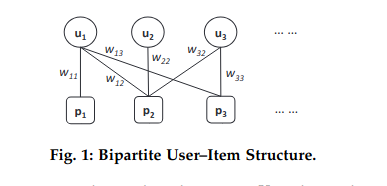

Reference:

He, X., Gao, M., Kan, M.-Y., & Wang, D. (2017). BiRank: Towards Ranking on Bipartite Graphs (No. arXiv:1708.04396). arXiv. https://doi.org/10.48550/arXiv.1708.04396


In [61]:
def birank(W, U0, P0, alpha=0.85, beta=0.85, max_iter=200, tol=1e-6, verbose=False):
    """
    A BiRank algorithm implementation for bipartite graph ranking.

    Args:
      W (coo_matrix) : Weight matrix for users and items (n_users x n_items).
      U0 (dia_matrix): Query matrix for users (n_users x n_users).
      P0 (coo_matrix): Query matrix for items (n_users x n_items).
      alpha, beta: hyper-parameters (Damping factors)
      max_iter: Maximum number of iterations
      tol: Tolerance for convergence
      verbose: If True, print the iteration information

    Returns:
      U (csr_matrix): Ranking matrix of users (n_users x n_users).
      P (csr_matrix): Ranking matrix of items for each user (n_users x n_items).
    """
    
    # Compute the row-sum and col-sum of weight maxtrix
    du = np.asarray(W.sum(axis=1)).ravel()
    dp = np.asarray(W.sum(axis=0)).ravel()

    # avoid division by zero
    eps = 1e-6
    # du = np.maximum(du, eps)
    # dp = np.maximum(dp, eps)
    du[du == 0] = eps
    dp[dp == 0] = eps

    # inverse square root of the row-sum and col-sum and form diagonal matrix
    du_inv_sqrt = spa.diags(1 / np.sqrt(du)).tocsr()
    dp_inv_sqrt = spa.diags(1 / np.sqrt(dp)).tocsr()

    #Symmetrically normalized weight matrix and convert it into csr for efficient matrix multiplication for update rule
    S = du_inv_sqrt @ W @ dp_inv_sqrt
    S = S.tocsr()
    St = S.T

    #initalize the user and item as query matrices
    U_last = U0.copy()
    P_last = P0.copy()

    for itr in range(max_iter):
        # update rules for items and users
        P = alpha * (St @ U_last).T + (1 - alpha) * P0
        U = beta * (S @ P_last.T) + (1 - beta) * U0

        # compute the frobinus norm to get the errors from the previous
        p_error = la.norm((P - P_last).toarray(), ord="fro")
        u_error = la.norm((U - U_last).toarray(), ord="fro")

        if verbose:
            print(f"Iteration: {itr}, Item Rank Error: {p_error}, User Rank Error: {u_error}")

        if p_error < tol and u_error < tol:
            print(f"converged after {itr} iterations")
            break
        P_last, U_last = P, U

    return U, P

In [26]:
def generate_birank(W, verbose=False):
  """
    generate birank

    Args:
      W: A sparse matrix of users and movies (n_users x num_items)
      U0: A sparse matrix of users and users (n_users x n_users)
      P0: A sparse matrix of user and items (n_users x num_items)

    Returns:
      U: A sparse matrix of users and users (n_users x n_users)
      P: A sparse matrix of users and items (n_users x num_items)
  """

  U0 = spa.eye(W.shape[0]).tocsr()
  P0 = W.copy().tocsr()
  return birank(W, U0, P0, verbose=verbose)

In [28]:
def generate_unique_index(data_df, user_col_name, item_col_name):
    """
    Create unique index for users and items
    
    Args:
        data_df: A pandas dataframe of users, items, and ratings
        user_col_name: column name of the users 
        item_col_name: column name of the items
    
    Returns:
        data_df: A pandas dataframe with added user_index and item_index columns
    """
    # Create user index mapping
    user_ids = (data_df[user_col_name]
                .unique()
                .reshape(-1,1))
    user_ids = pd.DataFrame(user_ids, columns=[user_col_name])
    user_ids['user_index'] = range(len(user_ids))

    # Create item index mapping 
    item_ids = (data_df[item_col_name]
                .unique()
                .reshape(-1,1))
    item_ids = pd.DataFrame(item_ids, columns=[item_col_name])
    item_ids['item_index'] = range(len(item_ids))

    # Merge indexes back to original dataframe
    data_df = (data_df
               .merge(user_ids, on=user_col_name, how='left')
               .merge(item_ids, on=item_col_name, how='left'))
    
    del user_ids
    del item_ids
    gc.collect()

    return data_df

In [29]:
def create_adj_matrix(data_df, user_index_col, item_index_col, weight_col_name, shape = None, normalize=False, verbose=False) -> spa.coo_matrix:
  """
    create adjacency matrix

    Args:
      data_df: A pandas dataframe of users, movies, and ratings
      user_col_name: column name of the users
      item_col_name: column name of the movies
      weight_col_name: column name of the ratings

    Returns:
      W: scipy.sparse.csr_matrix sparse matrix of users and movies
  """

  # Determine the shape of the matrix
  if shape is None:
    n_users = data_df[user_index_col].max() + 1
    n_items = data_df[item_index_col].max() + 1
    shape = (n_users, n_items)

  weights = data_df[weight_col_name].values
  
  # Normalize the weights
  if normalize:
    weights = (weights - weights.mean() / weights.std())
    

  W = spa.coo_matrix(
    (
      weights,
      (data_df[user_index_col].values, data_df[item_index_col].values)
    ),
    shape=shape
  ).tocsr()

  if verbose:
    print(f"Matrix shape: {W.shape}")
    # print(f"Matrix density: {W.nnz / W.shape[0] * W.shape[1]}")
    print(f"Memory usage: {W.data.nbytes / (1024 ** 2)} MB")

  return W

In [30]:
print(f"# unique users: {movie_ratings_df["userId"].nunique()},\
       #unique items: {movie_ratings_df["movieId"].nunique()}")

# unique users: 610,       #unique items: 9724


In [32]:
#set user, item, weight col names
user_col = 'userId'
item_col = 'movieId'
# generate unique indexes for users and movies(items)
movie_ratings_all_df = generate_unique_index(movie_ratings_df, user_col, item_col)

In [33]:
# free up some spaces
del movie_ratings_df
gc.collect()

0

In [77]:
def custom_train_test_split(data_df, test_size=0.1, min_ratings=3):
    # split the data into train and test but with the train_test_split we can't make sure that 
    # we have at least one user in the test so we pick randomly 5 ratings from each user and put it in 
    # the test the rest would be in the training
    
    # np.random.seed(42)
    train_df, test_df = train_test_split(data_df, test_size=test_size, random_state=42)
    #pick 5 ratings per user randomly 

    # test_df = data_df[data_df['rating'] >= min_ratings].groupby("userId").apply(lambda x: x.sample(test_size), include_groups=False).reset_index()
    
    #remove those entries in the test_df 
    # train_df = data_df.merge(test_df[["userId", "movieId"]], on=["userId", "movieId"], how="left", indicator=True)
    # train_df = train_df[train_df["_merge"] == "left_only"].drop(columns=["_merge"])
    return train_df, test_df

In [78]:
train_df, test_df = custom_train_test_split(movie_ratings_all_df)
#num unique users in test
print(test_df.userId.nunique())
#num unique users in train
print(train_df.userId.nunique())

603
610


In [79]:
train_df.shape, test_df.shape

((90752, 8), (10084, 8))

In [80]:
#each user rated a minimum and a maximum of 20 movies and 2698 movies respectively
user_rating_count = test_df.groupby("userId", sort=False)['title'].count().sort_values(ascending=False)
print(f"min # of movies rated by a user: {user_rating_count.min()}")
print(f"max # of movies rated by a user: {user_rating_count.max()}")

#movies with more than 20 ratings
print(f"Movies with more than 20 ratings:\n {rating_count[rating_count >= 20].head()}")
print(f"# movies with more than 20 ratings:\n {rating_count[rating_count >= 20].count()}")
print(f"# movies with less than 20 ratings:\n {rating_count[rating_count < 20].count()}")
print(f"# movies with only 1 rating:\n {rating_count[rating_count <= 1].count()/test_df['movieId'].nunique()*100 :.2f}%")
import gc
del user_rating_count
gc.collect()

min # of movies rated by a user: 1
max # of movies rated by a user: 288
Movies with more than 20 ratings:
 movieId
356     329
318     317
296     307
593     279
2571    278
Name: rating, dtype: int64
# movies with more than 20 ratings:
 1297
# movies with less than 20 ratings:
 8427
# movies with only 1 rating:
 94.33%


6339

In [81]:
def combine_rank_phase(data_df, weight_col = 'rating',
                item_index_col = 'item_index',
                user_index_col = 'user_index'
    ):
    #set weight col
    weight_col = 'rating'
    
    #set user and item index col names
    item_index_col = 'item_index'
    user_index_col = 'user_index'

    # create adjacency matrix
    W = create_adj_matrix(data_df, user_index_col, item_index_col, weight_col)

    # Generate BiRank scores
    U, P = generate_birank(W, verbose=True)

    return U, P, W, data_df

In [82]:
def combine_rank_phase_chunk(data_df, weight_col = 'rating',
                item_index_col = 'item_index',
                user_index_col = 'user_index',
                chunk_size = 1000
    ):
    #set weight col
    weight_col = 'rating'
    
    #set user and item index col names
    item_index_col = 'item_index'
    user_index_col = 'user_index'

    # create adjacency matrix
    W = create_adj_matrix(data_df, user_index_col, item_index_col, weight_col)

    # Generate BiRank scores
    U, P = generate_birank_chunked(W, chunk_size=chunk_size, verbose=True)

    return U, P, W, data_df

In [83]:
def generate_personalized_recommendations(W, P):
    interaction_mask = (W > 0).toarray()

    # Mask the recommendation matrix P; collect only items users haven't interacted for recommendation
    P_masked = np.where(interaction_mask, -np.inf, P.toarray())

    return np.argsort(-P_masked, axis=1)

In [84]:
def get_top_n_recommendations(W, P, top_n=None):
    recommendations = generate_personalized_recommendations(W, P)
    return recommendations[:, :top_n] if top_n else recommendations

In [289]:
start = time.time()
U, P, W, _ = combine_rank_phase(train_df)
print(f"Time taken: {(time.time() - start) / 60 } min")
print(f"W: {W.shape}, U: {U.shape}, P: {P.shape}")

Iteration: 0, Item Rank Error: 931.9012922878313, User Rank Error: 459.50007776381796
Iteration: 1, Item Rank Error: 339.01692412501137, User Rank Error: 395.386801437089
Iteration: 2, Item Rank Error: 288.72625832601926, User Rank Error: 277.4953164270375
Iteration: 3, Item Rank Error: 232.97018397652326, User Rank Error: 235.97099091300336
Iteration: 4, Item Rank Error: 198.05009789372954, User Rank Error: 197.08149867910592
Iteration: 5, Item Rank Error: 167.17750233299677, User Rank Error: 167.5274458529965
Iteration: 6, Item Rank Error: 142.1038955545057, User Rank Error: 141.96829424686484
Iteration: 7, Item Rank Error: 120.61920514424828, User Rank Error: 120.67426365617452
Iteration: 8, Item Rank Error: 102.52683918521295, User Rank Error: 102.5037176817979
Iteration: 9, Item Rank Error: 87.11842044438974, User Rank Error: 87.12838645236651
Iteration: 10, Item Rank Error: 74.05075954738855, User Rank Error: 74.04637166406715
Iteration: 11, Item Rank Error: 62.93749602771106, Us


### Evaluation


In [277]:
def calculate_metrics(test_df, W, P, top_n=100):
    """
    Calculate HR@N, NDCG@N, and MRR for recommendations
    
    Args:
        test_df: DataFrame containing test interactions
        W: User-item interaction matrix
        P: BiRank recommendation matrix
        top_n: Number of top items to consider
    
    Returns:
        Dictionary containing HR@N, NDCG@N, and MRR values
    """
    metrics = {}
    top_n_recommendations = get_top_n_recommendations(W, P, top_n)
    
    hits = 0
    ndcg_scores = []
    reciprocal_ranks = []
    
    # Get unique users for proper averaging
    unique_users = test_df['user_index'].unique()
    total_users = len(unique_users)
    
    for user_idx in unique_users:
        # Get actual items for this user in test set
        actual_items = set(test_df[test_df['user_index'] == user_idx]['item_index'])
        
        if user_idx >= len(top_n_recommendations):
            continue
            
        user_recs = top_n_recommendations[user_idx]
        
        # Calculate metrics for this user
        user_metrics = calculate_user_metrics(user_recs, actual_items, top_n)
        
        # Accumulate metrics
        if user_metrics['hit']:
            hits += 1
        ndcg_scores.append(user_metrics['ndcg'])
        reciprocal_ranks.append(user_metrics['rr'])
    
    # Calculate final metrics
    metrics['HR@N'] = hits / total_users if total_users > 0 else 0
    metrics['NDCG@N'] = np.mean(ndcg_scores)
    metrics['MRR'] = np.mean(reciprocal_ranks)
    
    return metrics

def calculate_user_metrics(recommendations: np.ndarray, actual_items: set, top_n: int):
    """
    Calculate metrics for a single user
    """
    metrics = {'hit': False, 'ndcg': 0.0, 'rr': 0.0}
    
    #NDCG calculation
    dcg = 0
    idcg = 0

    # Find positions of actual items in recommendations
    for rank, item in enumerate(recommendations, 1):
        if item in actual_items:
            metrics['hit'] = True

            if metrics['rr'] == 0:
                metrics['rr'] = 1.0 / rank
            
            # NDCG calculation
            dcg += 1.0 / np.log2(rank + 1)

    # Calculate IDCG 
    n_relevant = len(actual_items)
    
    for i in range(1, n_relevant+1):  
        idcg += 1.0 / np.log2(i + 1)
       
    
    #calculate final NDCG
    metrics['ndcg'] = dcg / idcg
    return metrics

def evaluate_complete(test_df, W, P, top_ns=[5, 10, 20, 50, 100]):
    """
    Evaluate recommendations with multiple N values
    
    Args:
        test_df: Test data
        W: User-item interaction matrix
        P: BiRank recommendation matrix
        top_ns: List of N values to evaluate
    
    Returns:
        Nested dictionary with metrics for each N value
    """
    results = {}
    
    for n in top_ns:
        metrics = calculate_metrics(test_df, W, P, top_n=n)
        results[f'top_{n}'] = metrics
        
    return results

def print_evaluation_results(results: Dict[str, Dict[str, float]]):
    """
    print the evaluation results
    """
    print("\nEvaluation Results:")
    print("-" * 50)
    for n, metrics in results.items():
        print(f"\nMetrics for {n}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

In [170]:
# sort the test data based on the asumption that recent items are relevant
test_df.sort_values(by=["timestamp", "rating"], ascending=False, inplace=True)

In [235]:
test_df_new = test_df[test_df['rating'] >= 3.5]
test_df_new.shape

(6119, 8)

In [236]:
indx = (test_df_new["userId"].value_counts() > 30).keys()

In [237]:
test_df_update = test_df_new[test_df_new["userId"].isin(indx)]

In [238]:
test_df_update.shape

(6119, 8)


Evaluation Results:
--------------------------------------------------

Metrics for top_5:
HR@N: 0.4542
NDCG@N: 0.1198
MRR: 0.3075

Metrics for top_10:
HR@N: 0.5563
NDCG@N: 0.1483
MRR: 0.3213

Metrics for top_20:
HR@N: 0.6620
NDCG@N: 0.1791
MRR: 0.3285

Metrics for top_50:
HR@N: 0.7746
NDCG@N: 0.2213
MRR: 0.3323

Metrics for top_100:
HR@N: 0.8504
NDCG@N: 0.2513
MRR: 0.3335


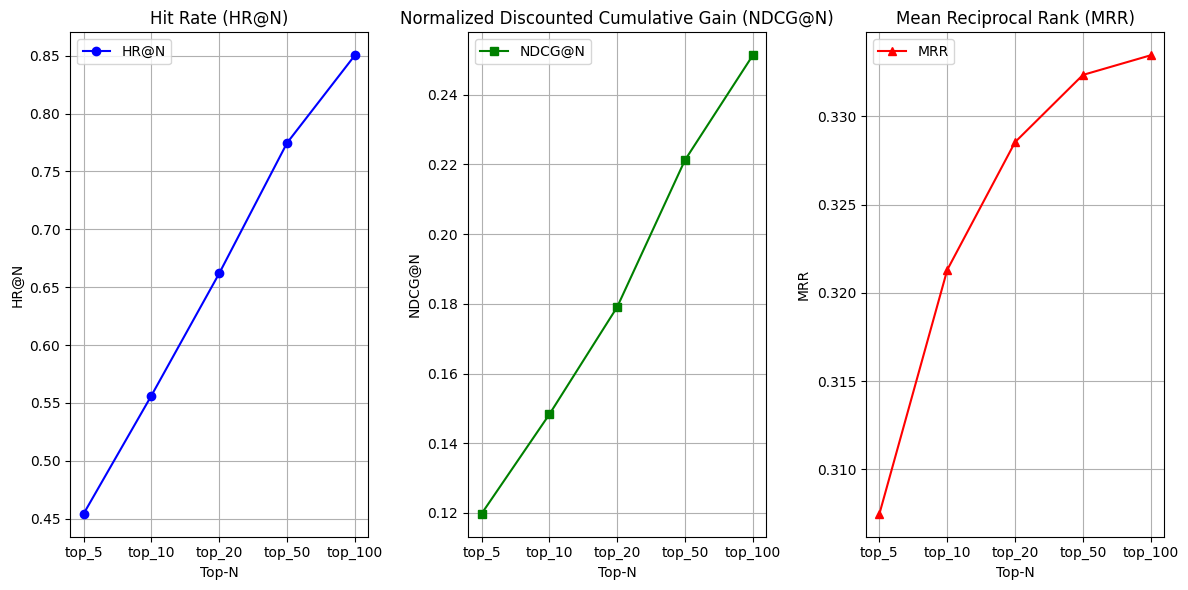

In [272]:
# After training model
test_results = evaluate_complete(test_df_update, W, P)
print_evaluation_results(test_results)
plot_results(test_results)


Evaluation Results:
--------------------------------------------------

Metrics for top_5:
HR@N: 0.4542
NDCG@N: 0.1198
MRR: 0.3075

Metrics for top_10:
HR@N: 0.5563
NDCG@N: 0.1483
MRR: 0.3213

Metrics for top_20:
HR@N: 0.6620
NDCG@N: 0.1791
MRR: 0.3285

Metrics for top_50:
HR@N: 0.7746
NDCG@N: 0.2213
MRR: 0.3323

Metrics for top_100:
HR@N: 0.8504
NDCG@N: 0.2513
MRR: 0.3335


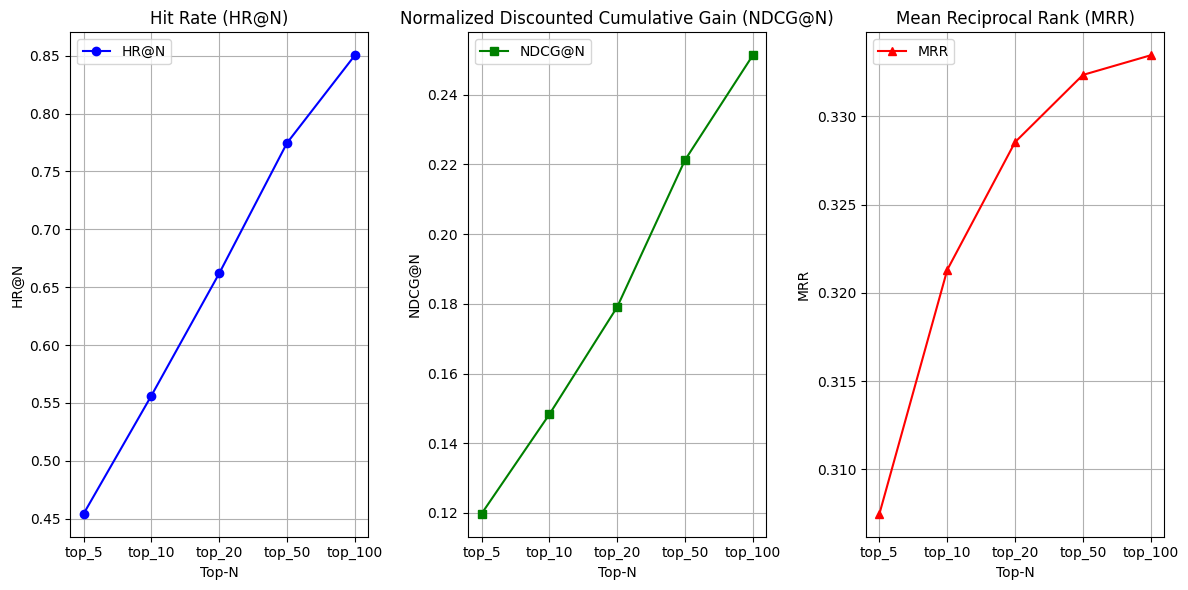

In [273]:
# After training your model
test_results = evaluate_complete(test_df_new, W, P)
print_evaluation_results(test_results)
plot_results(test_results)


Evaluation Results:
--------------------------------------------------

Metrics for top_5:
HR@N: 0.4909
NDCG@N: 0.1139
MRR: 0.3351

Metrics for top_10:
HR@N: 0.6119
NDCG@N: 0.1448
MRR: 0.3516

Metrics for top_20:
HR@N: 0.7197
NDCG@N: 0.1778
MRR: 0.3590

Metrics for top_50:
HR@N: 0.8176
NDCG@N: 0.2228
MRR: 0.3623

Metrics for top_100:
HR@N: 0.8823
NDCG@N: 0.2554
MRR: 0.3632


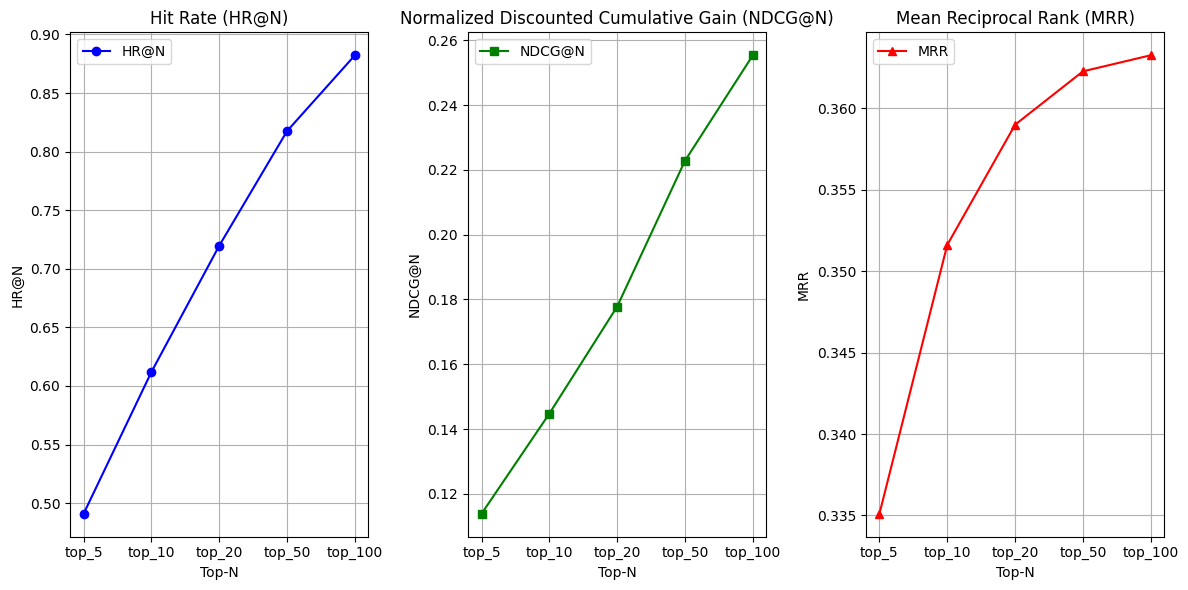

In [274]:
# After training your model
test_results = evaluate_complete(test_df, W, P)
print_evaluation_results(test_results)
plot_results(test_results)

In [271]:
def plot_results(test_results):
    top_values = list(test_results.keys())
    hr_list = [values['HR@N'] for values in test_results.values()]
    ndcg_list = [values['NDCG@N'].item() for values in test_results.values()]
    mrr_list = [values['MRR'].item() for values in test_results.values()]
    
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    
    # Plot HR@N
    axs[0].plot(top_values, hr_list, marker='o', color='b', label="HR@N")
    axs[0].set_title('Hit Rate (HR@N)')
    axs[0].set_xlabel('Top-N')
    axs[0].set_ylabel('HR@N')
    axs[0].grid(True)
    axs[0].legend()
    
    # Plot NDCG@N
    axs[1].plot(top_values, ndcg_list, marker='s', color='g', label="NDCG@N")
    axs[1].set_title('Normalized Discounted Cumulative Gain (NDCG@N)')
    axs[1].set_xlabel('Top-N')
    axs[1].set_ylabel('NDCG@N')
    axs[1].grid(True)
    axs[1].legend()
    
    # Plot MRR
    axs[2].plot(top_values, mrr_list, marker='^', color='r', label="MRR")
    axs[2].set_title('Mean Reciprocal Rank (MRR)')
    axs[2].set_xlabel('Top-N')
    axs[2].set_ylabel('MRR')
    axs[2].grid(True)
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()


In [285]:
top_n_recommendations = get_top_n_recommendations(W, P, 10)
top_n_recommendations.shape

(610, 10)

### Demo

In [286]:
def filter_results(user_id, data_df):
    user_index = data_df[data_df["userId"] == int(user_id)]["user_index"].unique().item()
    return data_df[data_df["item_index"].isin(top_n_recommendations[user_index])][["movieId", "title", "genres"]].drop_duplicates()

In [287]:
item_input = widgets.Text(
    value='User id',
    description='User Id:',
    disabled=False
)
item_list = widgets.Output()

def on_type(data):
    with item_list:
        item_list.clear_output()
        user_id = data["new"]
        if len(user_id.strip()) > 0 and user_id.isnumeric() and ('top_n_recommendations' in globals()):
            if int(user_id) > 0:
                recommendation_list = filter_results(user_id, test_df)
                display(recommendation_list if len(recommendation_list) > 0 else "User Id not exist")

item_input.observe(on_type, names='value')


display(item_input, item_list)

Text(value='User id', description='User Id:')

Output()